# Project Solution Lab 2: 

# Problem: Predicting Credit Card Fraud 

## Introduction to business scenario
You work for a multinational bank. There has been a significant increase in the number of customers experiencing credit card fraud over the last few months. A major news outlet even recently published a story about the credit card fraud you and other banks are experiencing. 

As a response to this situation, you have been tasked to solve part of this problem by leveraging machine learning to identify fraudulent credit card transactions before they have a larger impact on your company. You have been given access to a dataset of past credit card transactions, which you can use to train a machine learning model to predict if transactions are fraudulent or not. 


## About this dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred over the course of two days and includes examples of both fraudulent and legitimate transactions.

### Features
The dataset contains over 30 numerical features, most of which have undergone principal component analysis (PCA) transformations because of personal privacy issues with the data. The only features that have not been transformed with PCA are 'Time' and 'Amount'. The feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction amount. 'Class' is the response or target variable, and it takes a value of '1' in cases of fraud and '0' otherwise.

Features: 
`V1, V2, ... V28`: Principal components obtained with PCA

Non-PCA features:
- `Time`: Seconds elapsed between each transaction and the first transaction in the dataset, $T_x - t_0$
- `Amount`: Transaction amount; this feature can be used for example-dependent cost-sensitive learning 
- `Class`: Target variable where `Fraud = 1` and `Not Fraud = 0`

### Dataset attributions

Website: https://www.openml.org/d/1597

Authors: Andrea Dal Pozzolo, Olivier Caelen, and Gianluca Bontempi
Source: Credit card fraud detection - June 25, 2015
Official citation: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson, and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.
\# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.
\# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.
\# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.
\# Write your answer here


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [1]:
# Change the bucket according to your information
bucket = '<LabBucketName>'

In [2]:
%%capture

%pip install --upgrade boto3 -q
%matplotlib inline
%pip uninstall scikit-learn -y -q
%pip install imbalanced-learn==0.7.0 -q
%pip install --upgrade scikit-learn imbalanced-learn
%pip install imblearn -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()

### Downloading the dataset

In [4]:
# Check whether the file is already in the desired path or if it needs to be downloaded
import os
import subprocess
base_path = '/home/ec2-user/SageMaker/project/data/FraudDetection'
file_path = '/fraud.csv'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp', 
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/credit_card_project/', 
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

download: s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/credit_card_project/fraud.csv to ../project/data/FraudDetection/fraud.csv


# Step 2: Data preprocessing and visualization 
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Read the CSV data into a Pandas dataframe. You can use the built-in Python `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [5]:
df = pd.read_csv('/home/ec2-user/SageMaker/project/data/FraudDetection/fraud.csv')

Check the dataframe by printing the first 5 rows of the dataset.  

**Hint**: Use the `<dataframe>.head()` function.

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [7]:
# The class has a weird string instead of a boolean or numbers 0 and 1, so convert it to 0 and 1 

mapped_class = {"'0'": 0, "'1'": 1}
df['Class'] = df['Class'].map(lambda x: mapped_class[x])

In [8]:
# Check if that worked

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Question**: What is the shape of your dataset?  

**Hint**: To check the shape of a dataframe, use the `<dataframe>.shape` function.

In [9]:
df.shape

(284807, 31)

**Task**: Validate all the columns in the dataset and see that they are what you read above: `V1-V28`, `Time`, `Amount`, and `Class`.  

**Hint**: Use `<dataframe>.columns` to check the columns in your dataframe.

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**Question**: What can you find out about the column types and the null values? How many columns are numerical or categorical? 

**Hint**: Use the `info()` function to check.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Question**: Perform basic statistics using the Pandas library and `Describe` function. What is the mean and standard deviation for the `amount` feature? What can you deduce from those numbers?

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Answer:** Using the `describe` function, you can find some salient features of the dataset. 

- The mean amount for this dataset is \\$88 but this also consists of a lot of not fraud examples. But the max amount goes up to \\$25.
- The standard deviation for the Amount column is \\$250.

**Question**: What is the mean, standard deviation, and maximum for the `amount` for the records that are fraud?  

**Hint**: Use the built-in `mean()`, `std()`, and `max()` functions in dataframes.

In [13]:
print("Fraud Statistics")

avg_amt = df[df['Class']== 1]['Amount'].mean()
std_dev = df[df['Class']== 1]['Amount'].std()
max_amt = df[df['Class']== 1]['Amount'].max()

print(f"The average amount is {avg_amt}")
print(f"The std deviation for amount is {std_dev}")
print(f"The max amount is {max_amt}")

Fraud Statistics
The average amount is 122.21132113821139
The std deviation for amount is 256.68328829771207
The max amount is 2125.87


Now look at the target variable, `Class`. First, you can find out what the distribution is for it.
 
**Question**: What is the distribution of the classes?  

**Hint**: Use `<dataframe>['column_name'].value_counts()` to check the distribution.

In [14]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Question**: What can you deduce from the distribution of the classes?

**Answer:** The target variable distribution is very skewed. There are a lot of **not fraud** examples and very few **fraud** examples. 

**Question**: What's the ratio of classes for 0s to the total number of records?

In [15]:
284315/(284315+492)

0.9982725143693799

## Visualize your data
If you haven't done so in the above, you can use the space below to further visualize some of your data. Look specifically at the distribution of features like `Amount` and `Time`, and also calculate the linear correlations between the features in the dataset. 

### Specific questions to consider
1. After looking at the distributions of features like `Amount` and `Time`, to what extend might those features help your model? Is there anything you can deduce from those distributions that might be helpful in better understanding your data?

2. Do the distributions of features like `Amount` and `Time` differ when you are looking only at data that is labeled as fraud?

3. Are there any features in your dataset that are strongly correlated? If so, what would be your next steps?

Use the cells below to visualize your data and answer these and other questions that might be of interest to you. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and similar questions in your project presentations.</span>

Start with a simple scatter plot. Plot V1 vs. V2. For more information about plotting a scatter plot, see the [Matplotlib documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html).

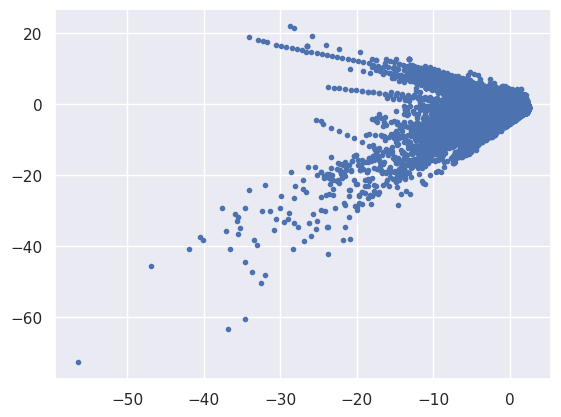

In [16]:
plt.plot(df['V1'], df['V2'],'.')

Look at a distribution of some of the features. Use `sns.displot()` to find the distribution of the individual features such as `Amount` and `Time`.

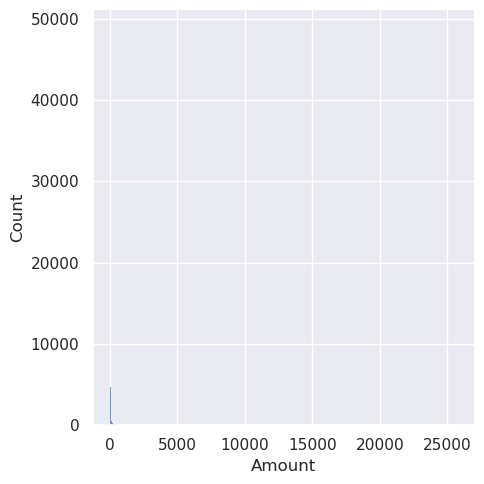

In [17]:
sns.displot(df['Amount'])

**Question**: Would the `Time` feature help you in any way? Look at the distribution again. What can you deduce from the scatter plot?

**Answer:** This distribution plot tells us the same thing that we saw in the `describe` function above. Most of the values are closer to \\$100, but there are some that are bigger.

Plot a histogram and Kernel density estimation (KDE).

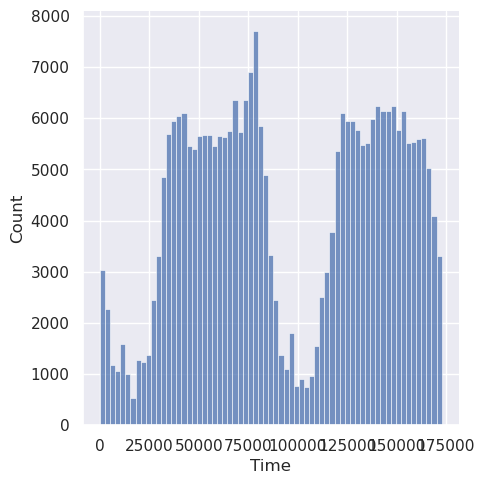

In [18]:
sns.displot(df['Time'])

The time distribution also confirms what the dataset told us. The data includes two days' worth of data where there are more credit card transactions during the day and fewer at night.

**Question**: What does this distribution look like for fraud cases for the `Amount` column?

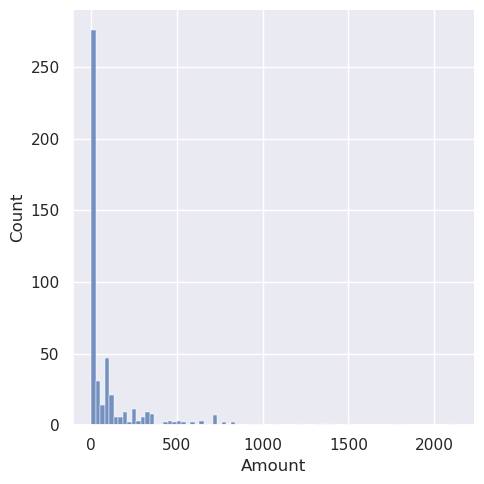

In [19]:
sns.displot(df[df['Class'] == 1]['Amount'])

Now let's look at a distribution using a Seaborn function called `pairplot`. `pairplot` creates a grid of scatterplots, such that each feature in the dataset is used once as the X-axis and once as the Y-axis. The diagonal of this grid shows a distribution of the data for that feature. 

Look at `V1`, `V2`, `V2`, `V4`, and `Class` pairplots. What do you see in the plots? Can you differentiate the fraud and not fraud from these features?  

**Hint**: Create a new dataframe with columns `V1`, `V2`, `V4`, and `Class`.

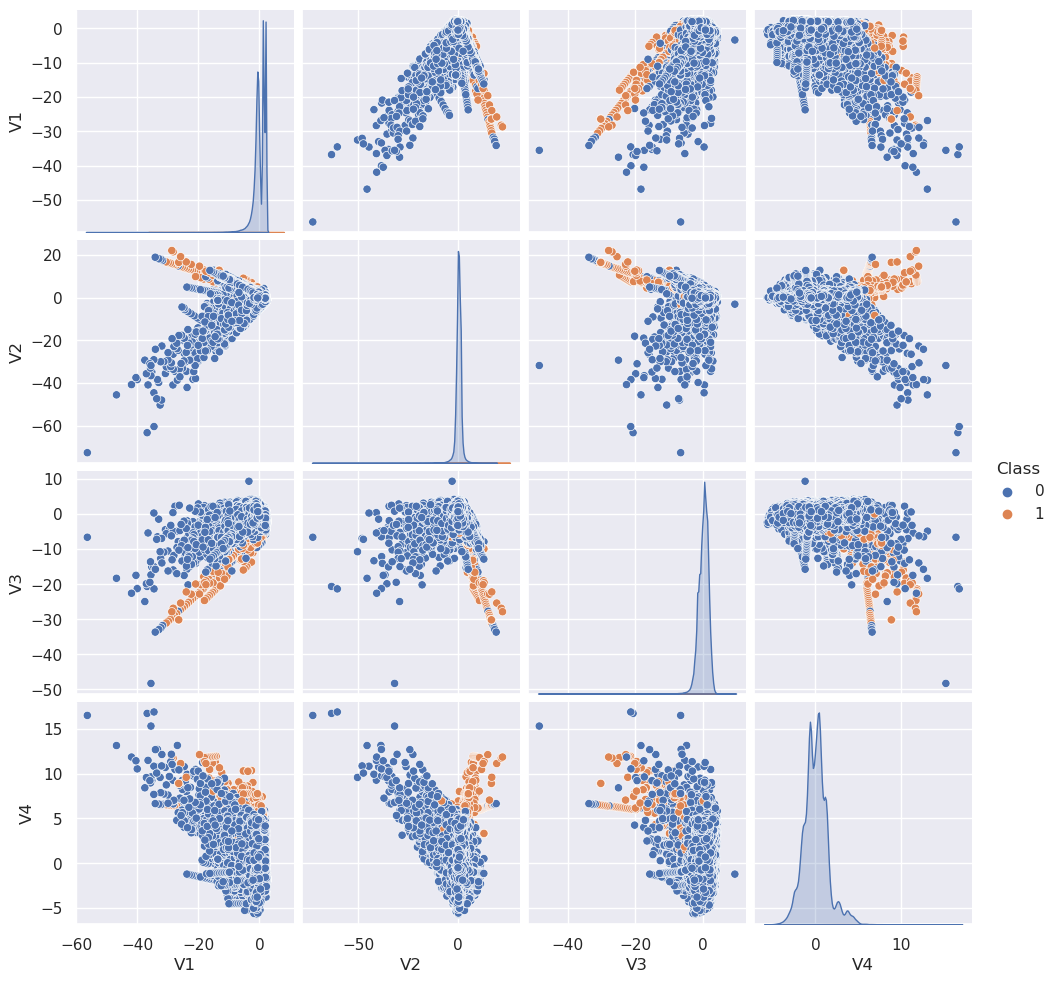

In [20]:
new_df = df[['V1', 'V2', 'V3', 'V4','Class']]
sns.pairplot(new_df, hue="Class")

You can see for the smaller subset of the features that we used, there is a way to differentiate the fraud and not fraud, but it's not easy to separate it based on any one feature.

Now, let's look at how these features interact with each other. Use the Pandas `corr` function to calculate the linear correlations between the features of the dataset. It is always easier to visualize the correlation. Plot the correlation using the Seaborn heatmap (`sns.heatmap`) function with the `annot` flag set to `True`.

<AxesSubplot: >

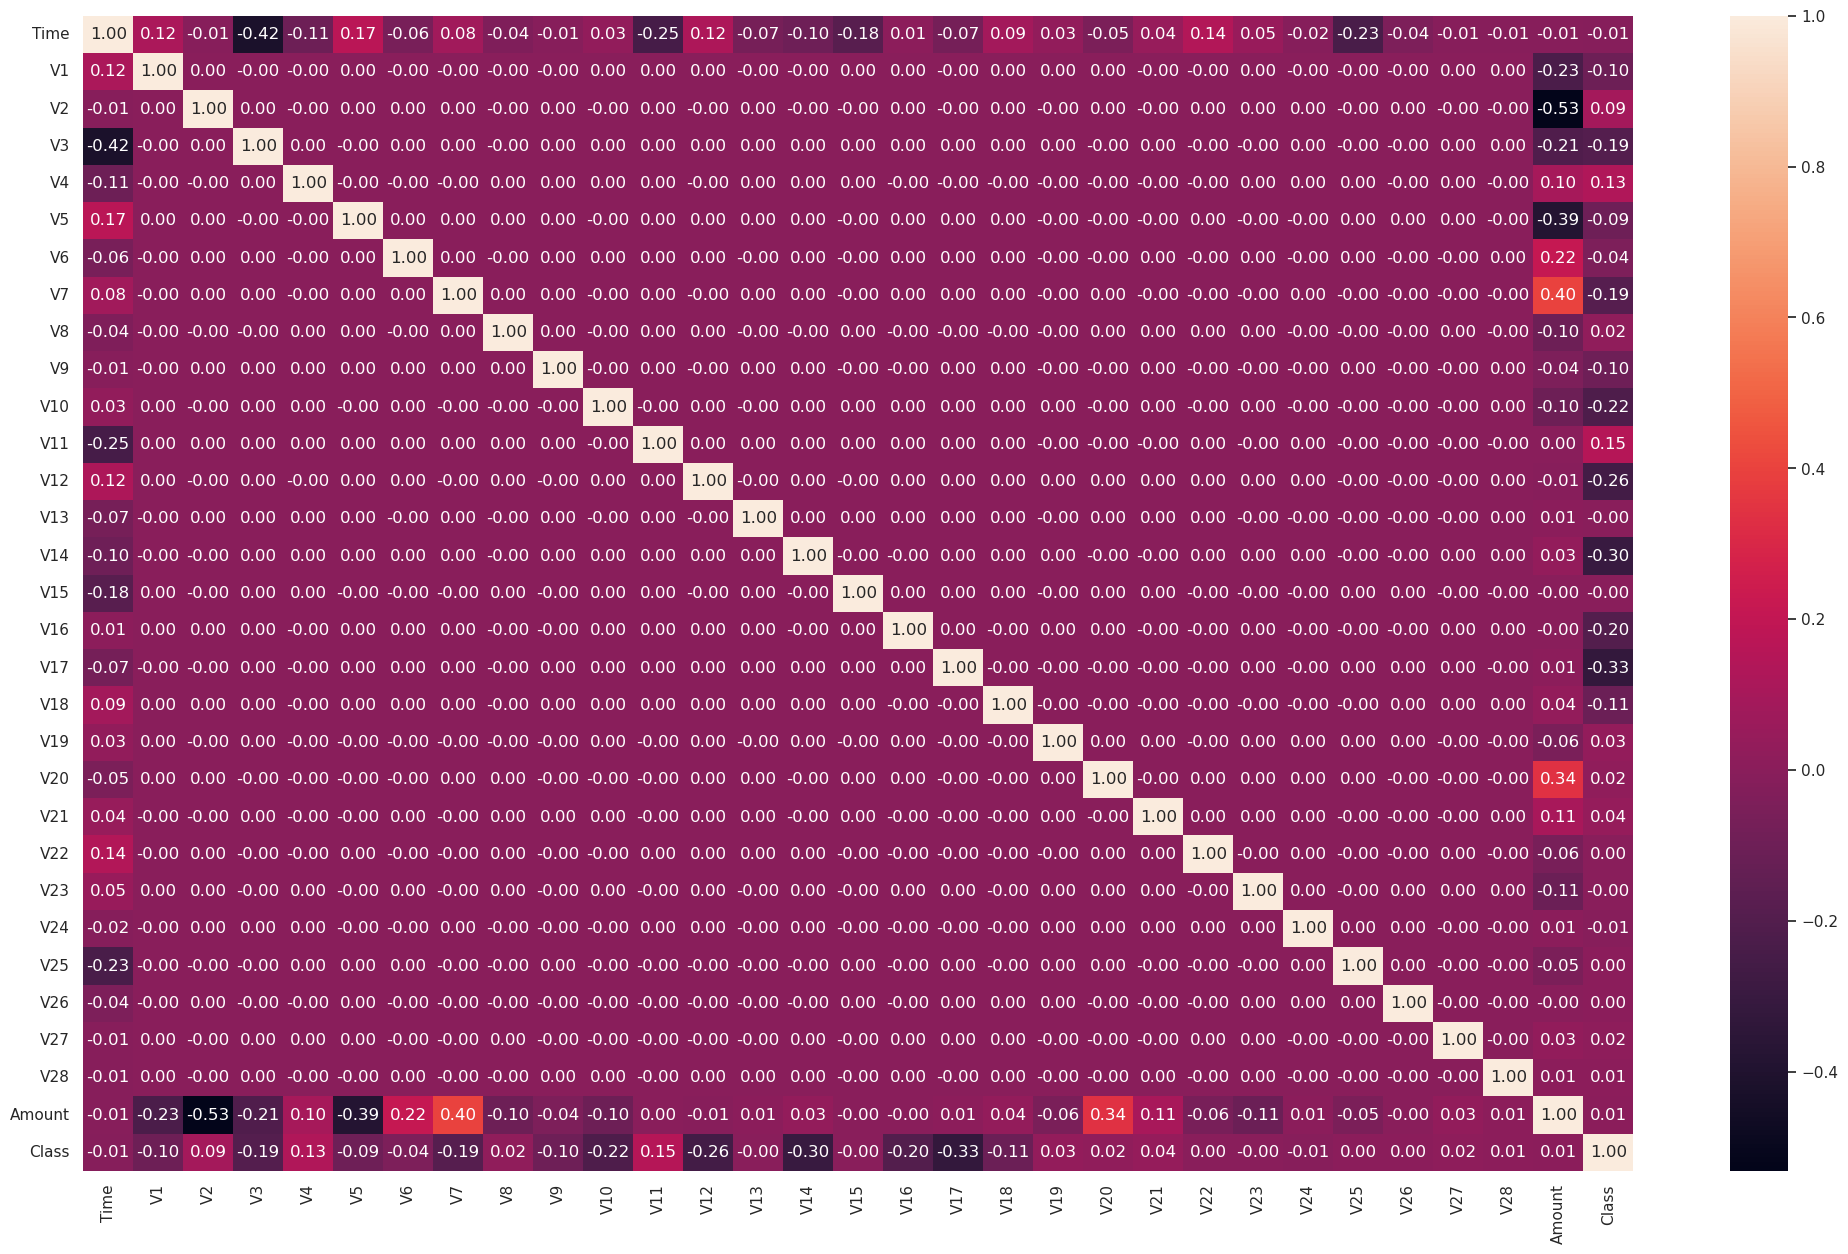

In [21]:
plt.figure(figsize = (25,15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True,fmt=".2f")

**Question**: For correlated features, you should remove one of them before model training. Do you see any features that you can remove?

**Answer**: There aren't any correlated features to be removed.

# Project Solution Lab 3: 

# Step 3: Model training and evaluation

There are some preliminary steps that you have to include when converting the dataset from a DataFrame to a format that a machine learning algorithm can use. For Amazon SageMaker, here are the steps you need to take:

1. Split the data into `train_data`, `validation_data`, and `test_data` using `sklearn.model_selection.train_test_split`.    
2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).    
3. Upload the data to your Amazon S3 bucket.

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Take note of the key decisions you've made in this phase in your project presentations.</span>

- The Amazon Simple Storage Service (Amazon S3) bucket and prefix(?) that you want to use for training and model data. This should be within the same Region as the Notebook Instance, training, and hosting.
- The AWS Identity and Access Management (IAM) role [Amazon Resource Name (ARN)](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) used to give training and hosting access to your data. See the documentation for how to create these.

**Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `get_execution_role()` call with the appropriate full IAM role ARN string(s).

In [22]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker.amazon.amazon_estimator import RecordSet

In [23]:
# Instantiate an Amazon SageMaker session
sess = sagemaker.Session()

# Get the Amazon SageMaker role 
role = get_execution_role()

# Get the image URI for the container that includes the linear learner algorithm
container = image_uris.retrieve('linear-learner',boto3.Session().region_name)

print(f'Session {sess}')
print(f'The role is {role}')
print(f'The container is {role} in the {boto3.Session().region_name} region')

Session <sagemaker.session.Session object at 0x7fdc82288b80>
The role is arn:aws:iam::431225565897:role/LabStack-mccuisp-mxgt8GHY-SageMakerNotebookInstanc-428Y6ZO9LECS
The container is arn:aws:iam::431225565897:role/LabStack-mccuisp-mxgt8GHY-SageMakerNotebookInstanc-428Y6ZO9LECS in the us-east-1 region


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data["Class"]).astype("float32")
    
    # Drop all the unwanted columns including the target column
    drop_list = ["Class","Time"]
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")
    
    np.random.seed(0)
    
    # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    train_features, test_features, \
    train_labels, test_labels = train_test_split(xs, ys, test_size=0.2, stratify=ys)
    
    # Use the sklearn function again to split the test dataset into 50% validation and 50% test
    val_features, test_features, \
    val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5, stratify=test_labels)
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels

In [25]:
# Use the function to create your datasets
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(df)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (227845, 29)
Length of train_labels is: (227845,)
Length of val_features is: (28481, 29)
Length of val_labels is: (28481,)
Length of test_features is: (28481, 29)
Length of test_labels is: (28481,)


In [26]:
print('Train class split')
tr_hist = np.histogram(train_labels, bins=2)[0]
print(tr_hist)
print(tr_hist[1]*1. / (tr_hist[0] + tr_hist[1]))

print('\nValidation class split')
val_hist = np.histogram(val_labels, bins=2)[0]
print(val_hist)
print(val_hist[1]*1. / (val_hist[0] + val_hist[1]))

print('\nTest class split')
test_hist = np.histogram(test_labels, bins=2)[0]
print(test_hist)
print(test_hist[1]*1. / (test_hist[0] + test_hist[1]))

Train class split
[227451    394]
0.001729245759178389

Validation class split
[28432    49]
0.0017204452090867595

Test class split
[28432    49]
0.0017204452090867595


### Model training

Lets start by instantiating the LinearLearner estimator with `predictor_type='binary_classifier'` parameter with one ml.m4.xlarge instance.

In [27]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet

# Instantiate the LinearLearner estimator object
num_classes = len(pd.unique(train_labels))

# Instantiate the LinearLearner estimator 'binary classifier' object with one ml.m4.xlarge instance
linear = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')

Linear learner accepts training data in protobuf or CSV content types, and accepts inference requests in protobuf, CSV, or JSON content types. Training data has features and ground-truth labels, while the data in an inference request has only features. In a production pipeline, it is recommended to convert the data to the Amazon SageMaker protobuf format and store it in Amazon S3. However, to get up and running quickly, AWS provides the convenient method `record_set` for converting and uploading when the dataset is small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so let's use it here. The `RecordSet` object will keep track of the temporary Amazon S3 location of your data. Use the `estimator.record_set` function to create train, validation, and test records. Then, use the `estimator.fit` function to start your training job.

In [28]:
### Create train, val, test records
train_records = linear.record_set(train_features, train_labels, channel='train')
val_records = linear.record_set(val_features, val_labels, channel='validation')
test_records = linear.record_set(test_features, test_labels, channel='test')

Now, lets train your model on the dataset that you just uplaoded.

In [29]:
### Fit the classifier
linear.fit([train_records,val_records], wait=True, logs='All')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-01-24-19-20-49-443


2023-01-24 19:20:50 Starting - Starting the training job...
2023-01-24 19:21:16 Starting - Preparing the instances for training.........
2023-01-24 19:22:32 Downloading - Downloading input data...
2023-01-24 19:23:07 Training - Downloading the training image......
2023-01-24 19:24:08 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/24/2023 19:24:29 INFO 140092044281664] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

## Model evaluation
In this section, you'll evaluate your trained model. First, use the `estimator.deploy` function with `initial_instance_count= 1` and `instance_type= 'ml.m4.xlarge'` to deploy your model on Amazon SageMaker.

In [30]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-01-24-19-27-49-973
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-01-24-19-27-49-973
INFO:sagemaker:Creating endpoint with name linear-learner-2023-01-24-19-27-49-973


----------!

Now that you have a hosted endpoint running, you can make real-time predictions from the model easily by making an http POST request. But first, you'll need to set up serializers and deserializers for passing your `test_features` NumPy arrays to the model behind the endpoint. You will also calculate the confusion matrix for your model to evaluate how it has done on your test data visually.

In [31]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
#from sagemaker.predictor import csv_serializer, json_deserializer,numpy_deserializer
#from sagemaker.predictor import csv_deserializer

def predict_batches(model, features, labels, split=200):
    """
    Predict datapoints in batches specified by the split. 
    The data will be split into <split> parts and model.predict is called 
    on each part
    Arguments:
        model: The model that you will use to call predict function
        features: The dataset to predict on
        labels: The true value of the records
        split: Number of parts to split the data into
    Returns:
        None
    """
    
    split_array = np.array_split(features, split)
    predictions = []
    for array in split_array:
        predictions +=  model.predict(array)

    # preds = np.array([p['predicted_label'] for p in predictions])
    preds = [i.label['predicted_label'].float32_tensor.values[0] for i in predictions]
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    print(f'Accuracy: {accuracy}')
    
    # Calculate precision
    precision = precision_score(labels, preds)
    print(f'Precision: {precision}')
    
    # Calculate recall
    recall = recall_score(labels, preds)
    print(f'Recall: {recall}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 
    

Now that your endpoint is 'InService', evaluate how your model performs on the test set. Compare that test set performance to the performance on the training set. 

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record answers to these and other similar questions you might answer in this section in your project presentations. Record key details and decisions you've made in your project presentations.</span>

Accuracy: 0.9994382219725431
Precision: 0.8666666666666667
Recall: 0.7959183673469388


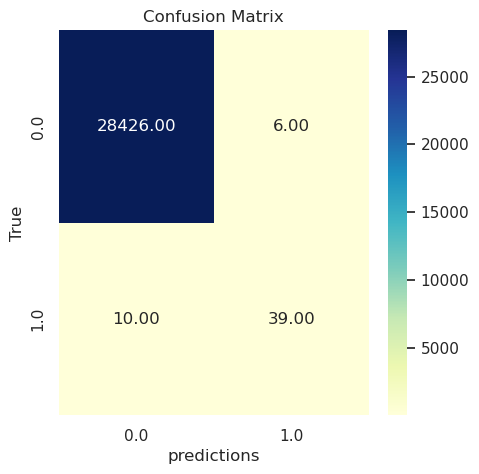

In [32]:
predict_batches(linear_predictor, test_features, test_labels)

Similar to the test set, you can also look at the metrics for the training set. Keep in mind that those are also shown to you above in the logs.

In [33]:
#predict_batches(linear_predictor, train_features, train_labels)

In [34]:
# Delete inference endpoint
sagemaker.Session().delete_endpoint(linear_predictor.endpoint_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-01-24-19-27-49-973


# Project Solution Lab 4: 

# Iteration II

# Step 4: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (fraud and not fraud) impact model performance?
2. Does balancing your dataset have any impact on correlations between your features?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record key decisions and methods you use in this section in your project presentations, as well as any new performance metrics you obtain after evaluating your model again.</span>

Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

**Answer**: Imbalanced datasets!

The accuracy is calculated with how many examples the model got right. However, most of the examples are actually negative, so if you actually predict all examples as zero in this very imbalanced dataset, you can still get an accuracy of about 99.827%. Having an imbalanced dataset may cause some problems with algorithm performance. So it's useful to treat the imbalance in the data before you train the model.

**Question**: How do you solve the problem of dataset imbalance?

**Answer:** You resample the dataset to create at least a balanced class distribution.

**Question**: Print the shape of your datasets again.

In [35]:
print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (227845, 29)
Length of train_labels is: (227845,)
Length of val_features is: (28481, 29)
Length of val_labels is: (28481,)
Length of test_features is: (28481, 29)
Length of test_labels is: (28481,)


Use `sns.countplot` to plot the original distribution of the dataset.

Text(0.5, 1.0, 'Original Distribution of the dataset')

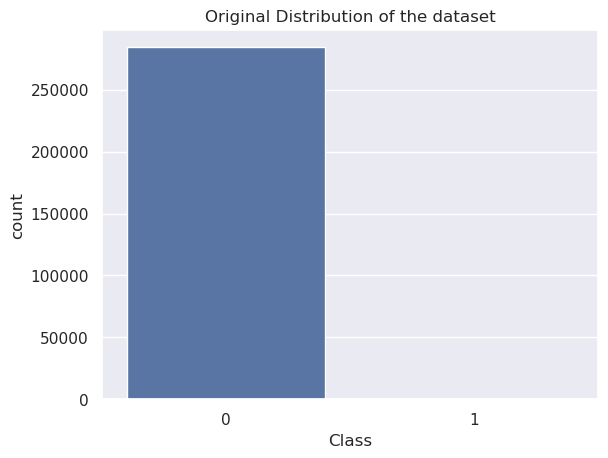

In [36]:
sns.countplot(x=df['Class'])
plt.title('Original Distribution of the dataset')

Convert `train_features` back into a DataFrame.

In [37]:
df_train = pd.DataFrame(train_features, columns = df.columns.drop(['Time','Class']))
df_train['Target'] = train_labels

In [38]:
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Target
0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,0.499167,...,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.669998,0.0
1,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,-0.658751,...,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595999,-0.220086,16.940001,0.0
2,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,-1.109522,...,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.000000,0.0
3,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,0.154307,...,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.780000,0.0
4,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,0.428729,...,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.959999,0.0


There are two main ways to handle imbalanced datasets:

- Oversample to add more positive samples
    - Random oversampling
    - [Synthetic minority oversampling technique (SMOTE)](https://arxiv.org/abs/1106.1813)
- Undersample to reduce the negative samples
    - Random undersampling
    - Generate centroids using clustering methods

You can use a library called `Imbalanced-learn` for sampling the datasets. `imbalanced-learn` is a Python package offering a number of resampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn and is part of scikit-learn-contrib projects. For more information, see [imbalanced-learn API documentation](https://imbalanced-learn.org/stable/introduction.html). 

Choose undersampling for this example first. To create the balanced dataset:

1. Create a new DataFrame `fraud_df` with all the positive examples.
2. Create another DataFrame `non_fraud_df` and use `dataframe.sample` with the same number as the `fraud_df` DataFrame and `random_state=235`.
3. Concatenate both DataFrames into a new DataFrame `balanced_df`.

In [39]:
fraud_df = df_train[df_train['Target'] == 1]

non_fraud_df = df_train[df_train['Target'] == 0].sample(n=len(fraud_df), random_state=235)

balanced_df = pd.concat([fraud_df, non_fraud_df], ignore_index=True, sort=False)

balanced_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Target
0,-7.334341,4.960892,-8.451409,8.174825,-7.237464,-2.382711,-11.508842,4.635798,-6.557760,-11.519861,...,2.153755,0.033922,-0.014095,0.625250,-0.053390,0.164709,1.411047,0.315645,11.380000,1.0
1,-5.839191,7.151532,-12.816760,7.031115,-9.651272,-2.938427,-11.543207,4.843626,-3.494276,-13.320789,...,2.462056,1.054865,0.530481,0.472670,-0.275998,0.282435,0.104886,0.254417,316.059998,1.0
2,-28.709229,22.057730,-27.855812,11.845013,-18.983812,6.474114,-43.557243,-41.044262,-13.320155,-24.588263,...,-22.797604,8.316276,5.466230,0.023854,-1.527145,-0.145225,-5.682338,-0.439134,0.010000,1.0
3,-1.739341,1.344521,-0.534379,3.195292,-0.416196,-1.261961,-2.340991,0.713004,-1.416265,-2.996669,...,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,0.000000,1.0
4,0.857321,4.093912,-7.423893,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,-3.944238,...,0.375026,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,1.000000,1.0


Check the distribution and shape again using `sns.countplot()`.

Text(0.5, 1.0, 'Balanced Distribution of the dataset')

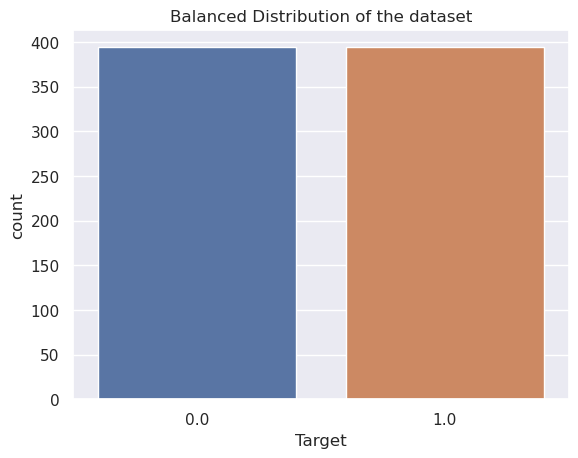

In [40]:
sns.countplot(x=balanced_df['Target'])
plt.title('Balanced Distribution of the dataset')

In [41]:
balanced_df.shape

(788, 30)

Before looking at the training, look at what will happen if you use a feature reduction technique like t-Distributed Stochastic Neighbor Embedding (t-SNE) on the dataset.

In [42]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(balanced_df.drop(columns = "Target"))
X_embedded.shape

(788, 2)

Text(0.5, 1.0, 'Red: 0 , Blue: 1')

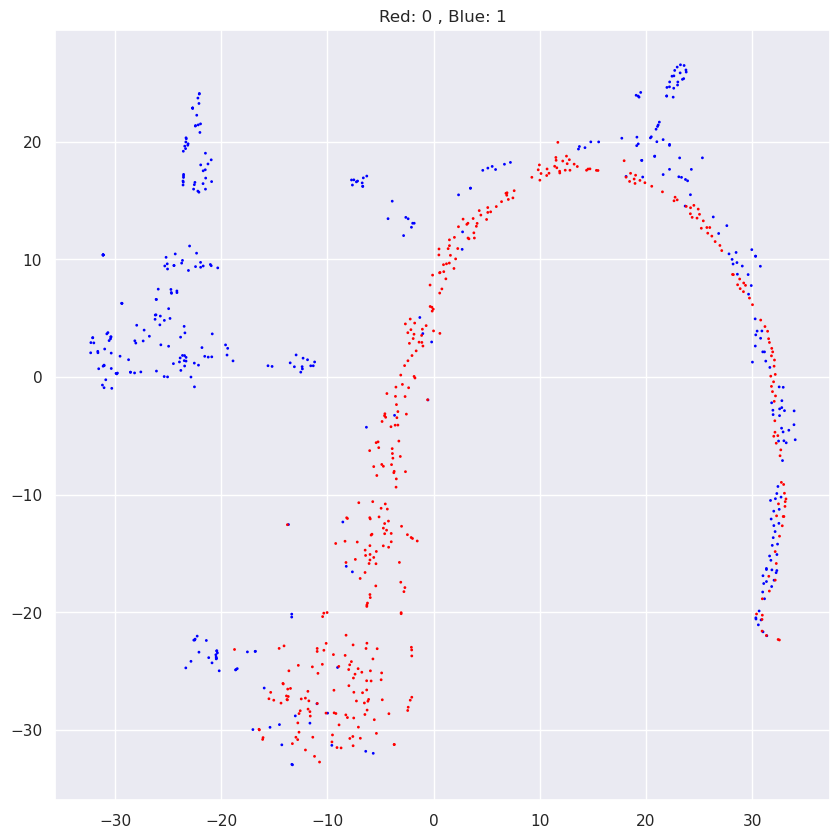

In [43]:
from matplotlib.colors import ListedColormap
plt.figure(figsize = (10,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], 
            c = balanced_df['Target'],
            s = 1,
            cmap = ListedColormap(['Red', 'Blue']),
            linewidths=1)

plt.title('Red: 0 , Blue: 1')

**Question:** Does t-SNE help you differentiate the fraud from not fraud?
    
**Answer:** t-SNE can differentiate between some of the fraud and not fraud cases, but it doesn't do a good job of completely differentiating the two when we reduce the data to just two dimensions.

Now that you have the new data, compare what the correlation matrix looks like before and after.

<AxesSubplot: >

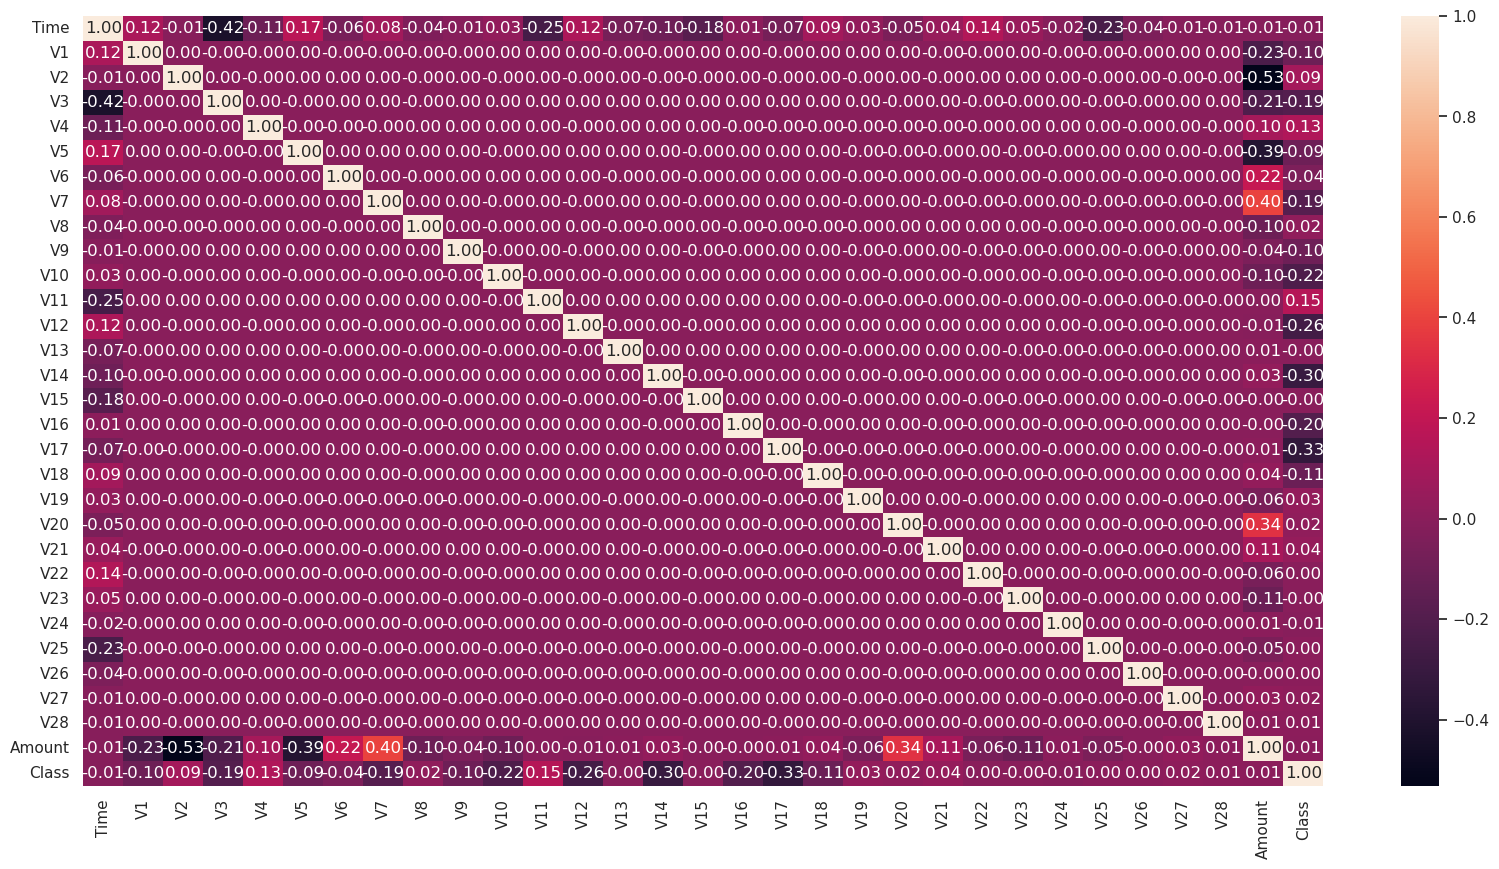

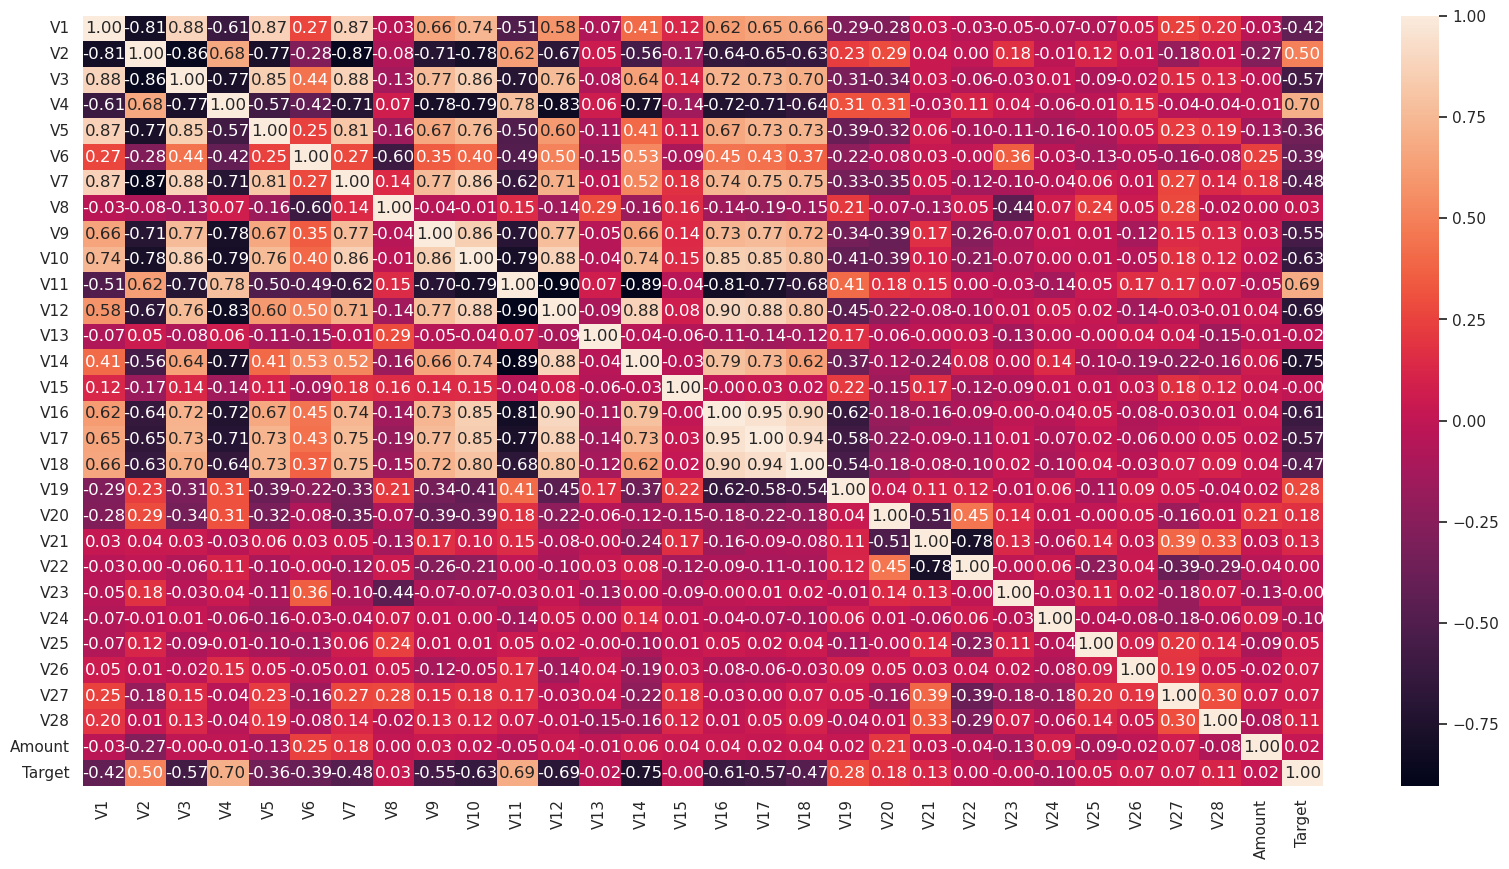

In [44]:
# Make sure to use the subsample in the correlation

plt.figure(figsize = (20,10))
correlation_matrix_before = df.corr()
sns.heatmap(correlation_matrix_before, annot=True,fmt=".2f")

plt.figure(figsize = (20,10))
correlation_matrix_after = balanced_df.corr()
sns.heatmap(correlation_matrix_after, annot=True,fmt=".2f")

**Question**: What can you deduce from looking at the different correlation matrices? If you see a difference, can you analyze why there is a difference?

**Answer:** In the unbalanced set, the correlation matrix didn't show any **linear** relationships, but in this smaller balanced dataset, you can see some linear relationships. 



**Question**: Would you drop any columns because of the correlated data?

**Answer:** Yes, remove any features that have more than 90% correlation.

Because there are some correlations, let's remove the correlated data that has more than 0.9 correlation. Run the following cell to drop the `V17` and `V18` columns.

In [45]:
balanced_df_drop = balanced_df.drop(columns=['V17','V18'])

Now it's time to train, deploy, and evaluate using the new balanced dataset.

In [46]:
# Instantiate the LinearLearner estimator object
num_classes = len(pd.unique(train_labels))
linear_estimator_balanced = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')


train_records_bal = linear_estimator_balanced.record_set(balanced_df.drop(['Target'], axis=1).values, 
                                                balanced_df['Target'].values, 
                                                channel='train')
val_records_bal = linear_estimator_balanced.record_set(val_features, val_labels, channel='validation')
test_records_bal = linear_estimator_balanced.record_set(test_features, test_labels, channel='test')

linear_estimator_balanced.fit([train_records_bal, val_records_bal])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-01-24-19-33-16-284


2023-01-24 19:33:16 Starting - Starting the training job......
2023-01-24 19:33:53 Starting - Preparing the instances for training............
2023-01-24 19:35:49 Downloading - Downloading input data...
2023-01-24 19:36:20 Training - Downloading the training image......
2023-01-24 19:37:31 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/24/2023 19:37:47 INFO 140215199627072] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 

Reducing the number of examples that make the distribution even caused the recall to go down rather than up. Let's try a different strategy, because we need a high recall.

Try using SMOTE to increase the number of positive examples.

In [47]:
from imblearn.over_sampling import SMOTE 

X = df.drop(['Class', 'Time'], axis=1).values
y = df['Class'].values

sm = SMOTE(random_state=35)
X_res, y_res = sm.fit_resample(X, y)



**Optional**: Convert the new dataset to a Pandas DataFrame and check the shape and distribution of the data.

In [48]:
smote_df = pd.DataFrame(X_res,columns = df.drop(['Class', 'Time'], axis=1).columns) 
smote_df['Class'] = y_res
smote_df['Time'] = df['Time']

Create new train, test, and validation datasets.

In [49]:
#X_res, y_res = X_res.astype("float32"), y_res.astype("float32")

train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(smote_df)

Train your model using the new dataset.

In [50]:
num_classes = len(pd.unique(train_labels))
linear_estimator_smote = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')


train_records_smote = linear_estimator_smote.record_set(train_features, train_labels, channel='train')
val_records_smote = linear_estimator_smote.record_set(val_features, val_labels, channel='validation')
test_records_smote = linear_estimator_smote.record_set(test_features, test_labels, channel='test')

linear_estimator_smote.fit([train_records_smote, val_records_smote])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-01-24-19-39-18-748


2023-01-24 19:39:18 Starting - Starting the training job...
2023-01-24 19:39:48 Starting - Preparing the instances for training.........
2023-01-24 19:41:11 Downloading - Downloading input data...
2023-01-24 19:41:41 Training - Downloading the training image.........
2023-01-24 19:42:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/24/2023 19:43:09 INFO 140529830557504] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'los

**Question**: What can you deduce from evaluating the training job?

**Answer**: Test recall improved a lot by using SMOTE on the training dataset. We are looking at the recall value, which is at 93% now. This is great, but can we still improve this number by changing some parameters? Let's try to use hyperparameter optimization to see if it would improve.

### Hyperparameter optimization
Another part of the model tuning phase is to perform hyperparameter optimization. This section gives you an opportunity to tune your hyperparameters to see the extent to which tuning improves your model performance. Use the following template code to help you get started launching an Amazon SageMaker hyperparameter tuning job and viewing the evaluation metrics. Use the following questions to help guide you through the rest of the section.

### Key questions to consider:
1. How does the outcome of your objective metric of choice change as timing of your tuning job increases? What's the relationship between the different objective metrics you're getting and time? 
2. What is the correlation between your objective metric and the individual hyperparameters? Is there a hyperparameter that has a strong correlation with your objective metric? If so, what might you do to leverage this strong correlation?
3. Analyze the performance of your model after hyperparameter tuning. Is current performance sufficient for what you need to solve your business problem?

#### <span style="color: blue;">Project presentation: Record key decisions and methods you use in this section in your project presentations, as well as any new performance metrics you obtain after evaluating your model again.</span>

In [51]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'wd': ContinuousParameter(1e-5, 1),
                        'l1': ContinuousParameter(1e-5, 0.01),
                        'learning_rate': ContinuousParameter(1e-4, 0.1)
                        }

objective_metric_name = 'validation:recall'

tuner = HyperparameterTuner(linear_estimator_smote,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3)

tuner.fit([train_records_smote, val_records_smote], include_cls_metadata=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: linear-learner-230124-1949


....................................................................................................!


### Track hyperparameter tuning job progress

After you launch a tuning job, you can see its progress by calling the `describe_tuning_job` API. The output from `describe-tuning-job` is a JSON object that contains information about the current state of the tuning job. You can call `list_training_jobs_for_tuning_job` to see a detailed list of the training jobs that the tuning job launched.

In [52]:
client = boto3.Session().client('sagemaker')
tuning_job_result = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
while status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
    job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
    print("%d training jobs have completed" % job_count)
    
    time.sleep(180)

    tuning_job_result = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
    status = tuning_job_result['HyperParameterTuningJobStatus']
    
print("\n\n All training jobs have completed")
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole




 All training jobs have completed


In [53]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 1, 24, 19, 54, 17, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:recall',
                                                 'Value': 0.9382386207580566},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 1, 24, 19, 55, 24, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:431225565897:training-job/linear-learner-230124-1949-005-659a2f9d',
 'TrainingJobName': 'linear-learner-230124-1949-005-659a2f9d',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 1, 24, 19, 54, 21, tzinfo=tzlocal()),
 'TunedHyperParameters': {'l1': '1.1247132565239094e-05',
                          'learning_rate': '0.006923962593861075',
                          'wd': '0.007682348798065492'}}


### Fetch all results as a DataFrame

You can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [54]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', 1) # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df



INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Number of training jobs with valid objective: 10
{'lowest': 0.8798888325691223, 'highest': 0.9382386207580566}


/tmp/ipykernel_14235/2846629638.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName


,l1,learning_rate,wd,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,0.000011,0.006924,0.007682,linear-learner-230124-1949-005-659a2f9d,Completed,0.938239,2023-01-24 19:54:21+00:00,2023-01-24 19:55:24+00:00,63.0
1,0.000013,0.014753,0.000133,linear-learner-230124-1949-009-bba2b128,Completed,0.937852,2023-01-24 19:55:40+00:00,2023-01-24 19:56:32+00:00,52.0
0,0.006089,0.100000,0.001649,linear-learner-230124-1949-010-5f955544,Completed,0.936867,2023-01-24 19:56:49+00:00,2023-01-24 19:57:41+00:00,52.0
7,0.000034,0.005951,0.055912,linear-learner-230124-1949-003-908699e0,Completed,0.936374,2023-01-24 19:51:37+00:00,2023-01-24 19:54:15+00:00,158.0
8,0.000019,0.061615,0.003139,linear-learner-230124-1949-002-868002dc,Completed,0.936339,2023-01-24 19:51:22+00:00,2023-01-24 19:54:00+00:00,158.0
2,0.000010,0.024678,0.004566,linear-learner-230124-1949-008-77993141,Completed,0.935917,2023-01-24 19:55:38+00:00,2023-01-24 19:56:30+00:00,52.0
4,0.000026,0.004156,0.001839,linear-learner-230124-1949-006-2a8dcc91,Completed,0.935390,2023-01-24 19:54:28+00:00,2023-01-24 19:55:25+00:00,57.0
3,0.000144,0.022041,0.022971,linear-learner-230124-1949-007-51cee9a6,Completed,0.935319,2023-01-24 19:56:06+00:00,2023-01-24 19:57:08+00:00,62.0
6,0.001296,0.000250,0.038472,linear-learner-230124-1949-004-9431529e,Completed,0.902012,2023-01-24 19:54:10+00:00,2023-01-24 19:55:07+00:00,57.0
9,0.000125,0.000174,0.018422,linear-learner-230124-1949-001-9c7dd02f,Completed,0.879889,2023-01-24 19:51:28+00:00,2023-01-24 19:54:11+00:00,163.0


**Question**: Does the model tuning help?

**Answer:** The tuned model gives recall that is around the same value on the test set as the non-tuned model when it comes to getting the fraud data points right.

### See tuning job results vs. time

Next you will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend toward better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether the number of training jobs is sufficient for the complexity of your search space.

In [55]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.hyperparameter_ranges().keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(width=900, height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

### Analyze the correlation between objective metric and individual hyperparameters

Now that you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between the objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [56]:
ranges = tuner_analytics.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(width=600, height=600, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

Deploy this as your final model and evaluate it on the test set.

In [57]:
tuned_model_deploy = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2023-01-24 19:55:37 Starting - Found matching resource for reuse
2023-01-24 19:55:37 Downloading - Downloading input data
2023-01-24 19:55:37 Training - Training image download completed. Training in progress.
2023-01-24 19:55:37 Uploading - Uploading generated training model
2023-01-24 19:55:37 Completed - Resource reused by training job: linear-learner-230124-1949-008-77993141

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-01-24-19-57-54-939


INFO:sagemaker:Creating endpoint-config with name linear-learner-230124-1949-005-659a2f9d
INFO:sagemaker:Creating endpoint with name linear-learner-230124-1949-005-659a2f9d


----------!

Accuracy: 0.9522888345672933
Precision: 0.967328100014537
Recall: 0.9361964053322078


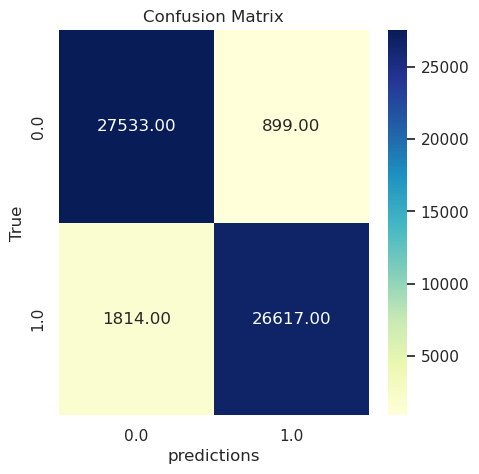

In [58]:
predict_batches(tuned_model_deploy, test_features, test_labels)

Accuracy: 0.9545750312153773
Precision: 0.9699305530305785
Recall: 0.9382386043894204


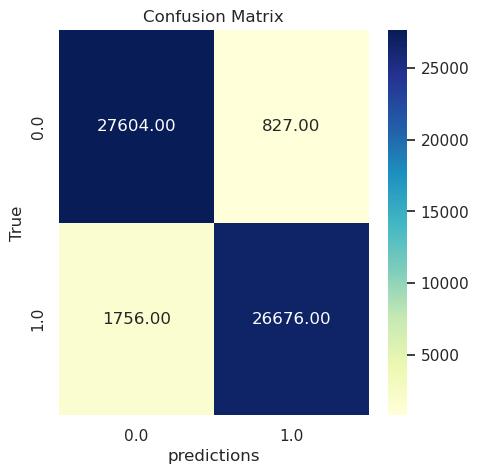

In [59]:
predict_batches(tuned_model_deploy, val_features, val_labels)

### OPTIONAL: Try the XGBoost algorithm
Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [60]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}


bucket = sess.default_bucket()
prefix = 'sagemaker/xgboost-creditcard'

from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('xgboost',boto3.Session().region_name, '1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Then, because you're training with the CSV file format, create s3_inputs that the training function can use as a pointer to the files in Amazon S3.

In [61]:
train_features_balanced = balanced_df.drop(['Target'], axis=1).values
train_labels_balanced = balanced_df['Target'].values

train_features_label = np.insert(train_features_balanced, 0, train_labels_balanced, axis=1)
val_features_label = np.insert(val_features, 0, val_labels, axis=1)
test_features_label = np.insert(test_features, 0, test_labels, axis=1)

np.savetxt("train.csv", train_features_label, delimiter=",")
np.savetxt("validation.csv", val_features_label, delimiter=",")

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Now, you can specify a few parameters like what type of training instances you'd like to use and how many, as well as the XGBoost hyperparameters. A few key hyperparameters are:

- `max_depth`: Controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample`: Controls sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round`: Controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. Again, more rounds should produce a better fit on the training data but can be computationally expensive or lead to overfitting.
- `eta`: Controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
- `gamma`: Controls how aggressively trees are grown. Larger values lead to more conservative models.

In [62]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=10,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=1,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric='auc',
                        num_round=100)

First, you need to specify training parameters to the estimator. This includes:

- The XGBoost algorithm container
- The IAM role to use
- Training instance type and count
- Amazon S3 location for output data
- Algorithm hyperparameters

And then a `.fit()` function, which specifies the Amazon S3 location for output data. In this case, you have both a training and validation set that are passed in.

In [63]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-01-24-20-03-16-580


2023-01-24 20:03:16 Starting - Starting the training job...
2023-01-24 20:03:42 Starting - Preparing the instances for training.........
2023-01-24 20:04:50 Downloading - Downloading input data...
2023-01-24 20:05:20 Training - Downloading the training image...
2023-01-24 20:06:01 Training - Training image download completed. Training in progress...[2023-01-24 20:06:19.751 ip-10-2-198-69.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:roo

### Hosting

Now that you've trained the XGBoost algorithm on the data, deploy a model that's hosted behind a real-time endpoint.

Deploy your model on Amazon SageMaker.

In [64]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(initial_instance_count=1, 
                           instance_type='ml.m4.xlarge',
                          serializer=CSVSerializer())

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-01-24-20-07-01-161
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-01-24-20-07-01-161
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-01-24-20-07-01-161


---------!

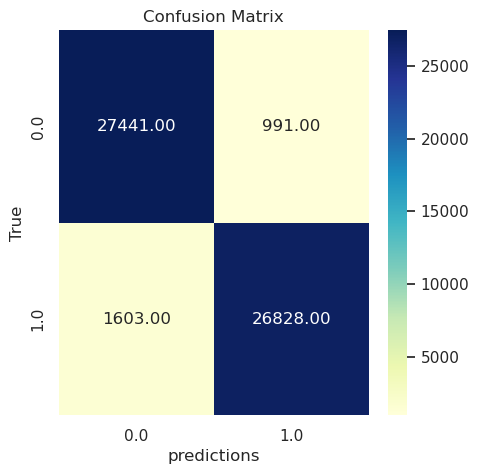

In [65]:
from sagemaker.serializers import CSVSerializer

def predict_xgboost(model, data, labels, rows=500):
    
    #model.content_type = 'text/csv'
    #model.serializer = csv_serializer
    #model.deserializer = None
    
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])
        
    preds = np.fromstring(predictions[1:], sep=',')
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 

predict_xgboost(xgb_predictor, test_features, test_labels)

In [66]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges_xgb = {'eta': ContinuousParameter(0.01, 0.2),
                         'max_depth': IntegerParameter(3, 9),
                         'gamma': IntegerParameter(0, 5),
                         'min_child_weight': IntegerParameter(2, 6),
                         'subsample': ContinuousParameter(0.5, 0.9),
                         'colsample_bytree': ContinuousParameter(0.5, 0.9)}

objective_metric_name_xgb = 'validation:auc'

tuner_xgb = HyperparameterTuner(xgb,
                            objective_metric_name_xgb,
                            hyperparameter_ranges_xgb,
                            max_jobs=10,
                            max_parallel_jobs=1)

tuner_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230124-2011


.......................................................................................................................................................!


In [67]:
client = boto3.Session().client('sagemaker')
tuning_job_result = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_xgb.latest_tuning_job.job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
while status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
    job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
    print("%d training jobs have completed" % job_count)
    
    time.sleep(180)

    tuning_job_result = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_xgb.latest_tuning_job.job_name)
    status = tuning_job_result['HyperParameterTuningJobStatus']
    
print("Training jobs have completed")
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Training jobs have completed


Deploy your tuned model on Amazon SageMaker.

In [68]:
xgb_predictor_tuned = tuner_xgb.deploy(initial_instance_count=1, 
                                       instance_type='ml.m4.xlarge',
                                       serializer=CSVSerializer() )


2023-01-24 20:22:01 Starting - Found matching resource for reuse
2023-01-24 20:22:01 Downloading - Downloading input data
2023-01-24 20:22:01 Training - Training image download completed. Training in progress.
2023-01-24 20:22:01 Uploading - Uploading generated training model
2023-01-24 20:22:01 Completed - Resource reused by training job: sagemaker-xgboost-230124-2011-008-0c0316d2


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-01-24-20-24-24-933
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-230124-2011-007-3dc47591
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-230124-2011-007-3dc47591


----------!

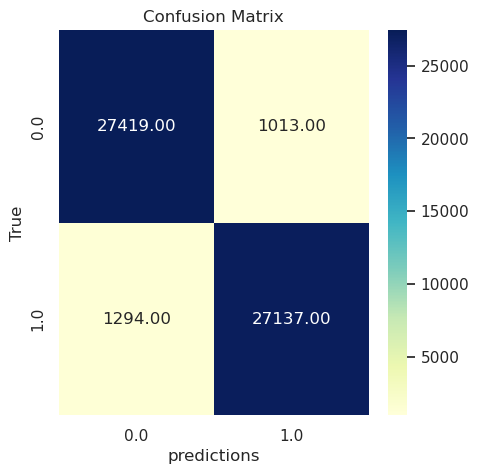

In [69]:
predict_xgboost(xgb_predictor_tuned, test_features, test_labels)

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset, features, and hyperparameters? What techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What outstanding questions do you have about aspects of the pipeline that just didn't make sense to you?
5. What were the three most important things you learned about machine learning while completing this project?

#### <span style="color: blue;">Project presentation: Summarize your answers to these questions in your project presentation as well. Pull together all of your notes for your project presentation at this point and prepare to present your findings to the class.</span>